In [22]:
#Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline


Introduction

The number of people who choose Airbnb for their accomodation is increasing nowadays. One of the important factors is cheaper price than traditional accomodations such as hotel, inn, and so on. What are the factors that affect the price? I analyze the data of 2016 Airbnb in Seattle to find the answer to this question.  


Business understanding

1. What are the busiest times of the year to visit Seattle? By how much do prices spike? 
2. Can you describe the vibe of each Seattle neighborhood using listing descriptions?
3. What are the main factors that the price of rooms? 


Data Understanding

1. What kind of data we have? 
2. How many rows and columns each file has?
3. What is the missing values we have? What is the proportion of missing values? 


In [23]:
# 1. What kind of data we have?
# 1) calendar.csv : listings of rooms and prices for each day. 
# 2) listings.csv : contains lists of rooms and information of hosts,location, price, structures of rooms and so on.
# 3) reviews.csv : reviews from customers - we are not using this file this time.

#Read the files
df_calendar = pd.read_csv('./calendar.csv')
df_listings = pd.read_csv('./listings.csv')
df_reviews = pd.read_csv('./reviews.csv')

In [24]:
# 2. How many rows and columns each file has? 

print("calendar.csv has", df_calendar.shape[0], "rows,", df_calendar.shape[1], "columns.");
print("listings.csv has", df_listings.shape[0], "rows,", df_listings.shape[1], "columns.");
print("reviews.csv has", df_reviews.shape[0], "rows,", df_reviews.shape[1], "columns.");

calendar.csv has 1393570 rows, 4 columns.
listings.csv has 3818 rows, 92 columns.
reviews.csv has 84849 rows, 6 columns.


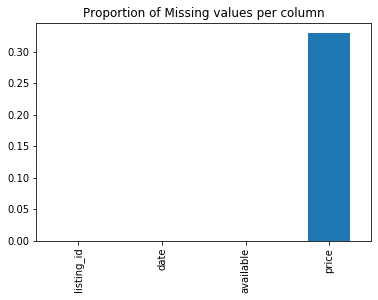

In [25]:
# 3. What is the missing values we have? What is the proportion of missing values? 
#proportion of missing values for each column in calendar.csv
missing_df_calendar = df_calendar.isnull().mean()
#bar chart for the results
missing_df_calendar.plot(kind="bar", title="Proportion of Missing values per column");

 

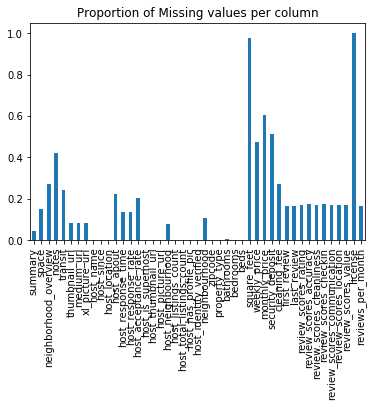

In [26]:
#find percentage of missing values for each column
missing_df_listings = df_listings.isnull().mean()
#find out columns that have missing values
missing_df_listings = missing_df_listings[df_listings.isnull().sum() > 0]
#plot the results
missing_df_listings.plot(kind="bar",title='Proportion of Missing values per column');

1. When do we need to travel to Seattle?
 
 What are the busiest times of the year to visit Seattle? By how much do prices spike? 



Data Preparation

1. Split the Month and year from date value in calendar.csv.
2. Change price format to float.
3. Remove rows which have Nan in price column.
4. Find out the correlation between price and time of the year.



In [27]:
# 1. Split the Month and year from date value in calendar.csv.
# before spliting the date, let's find the range of date. 
date_min = df_calendar['date'].min()
date_max = df_calendar['date'].max()

print("Listing dates are from", date_min, "to", date_max)

df_calendar['date']=df_calendar['date'].astype(str)

date = df_calendar['date'].str.split('-')
df_calendar = df_calendar.assign(year = date.apply(lambda x: int(x[0])),
                                 month = date.apply(lambda x: int(x[1])),
                                 day = date.apply(lambda x: int(x[2])))

df_calendar_split = df_calendar.drop(['date'], axis=1)


Listing dates are from 2016-01-04 to 2017-01-02


In [28]:
# 2. Change price format to float
df_calendar_split['price'] = df_calendar_split['price'].astype(str)
df_calendar_split['price'] = df_calendar_split['price'].str.replace("[$, ]", "").astype("float")


In [29]:
# 3. Remove rows which have Nan in price column.

# drop data of 2017 since we will consider only 2016 data and it distract our montly data analysis.
df_2017 = df_calendar_split[df_calendar_split['year']==2017].index
df_calendar_drop = df_calendar_split.drop(df_2017)

#drop Nan row in price column
df_calendar_drop = df_calendar_split.dropna(subset = ['price'])



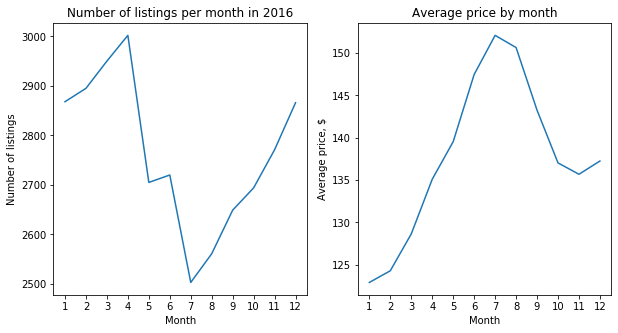

In [30]:
#4. Find out the correlation between price and time of the year.
# The price of room includes accomodation, cleaning fee, extra guests fee and so on.
# However, we will consider only the price of accomodation per a night.  
num_listings_per_month = pd.Series([12])

for i in range(1, 13):
    num_listings_per_month[i] = len(df_calendar_drop[(df_calendar_drop['month'] == i) & (df_calendar_drop['year'] == 2016)]['listing_id'].unique())

num_listings_per_month = num_listings_per_month.drop(0)

plt.figure(figsize = (10,5))
ticks = np.arange(1,13,step=1)
plt.subplot(1,2,1)
plt.plot(num_listings_per_month)
plt.xticks(ticks)
plt.ylabel('Number of listings')
plt.xlabel('Month')
plt.title('Number of listings per month in 2016')

plt.savefig('number of available listings.png')

#find average price by month

avg_price_month = df_calendar_drop.groupby('month')['price'].mean()

#plot
plt.subplot(1,2,2)
plt.plot(avg_price_month)
plt.xticks(ticks)
plt.ylabel('Average price, $')
plt.xlabel('Month')
plt.title('Average price by month')

plt.savefig('average price by month')

Results: As we can see in the above graphs, number of listings are low in July and August. On the other hand, Average price increased in July and August. 
Therefore, we can say that summer is the most popular season in the year and the number of listings is in inverse proportion to the average price of room. 

2. Vibe of each Seattle Neighborhood

  Can you describe the vibe of each Seattle neighborhood using listing descriptions?


Data Preparation

1. Change price format to float.
2. Remove columns that we don't need from listings.csv.
3. Remove rows which have missing values.
4. Find out the correlation between neighborhood and the price of rooms. 


In [31]:
# 1. Change price format to float
df_listings['price'] = df_listings['price'].astype(str)
df_listings['price'] = df_listings['price'].str.replace("[$, ]", "").astype("float")


In [32]:
# 2. Drop columns that we don't need.
df_listings_drop = df_listings[['neighbourhood_group_cleansed', 'price']]


In [33]:
# 3. Remove rows that have Nan in any column
# Selected columns' proportions of missing values are less than 0.2, so I just drop the rows. 
df_listings_drop = df_listings_drop.dropna(how='any', axis=0)



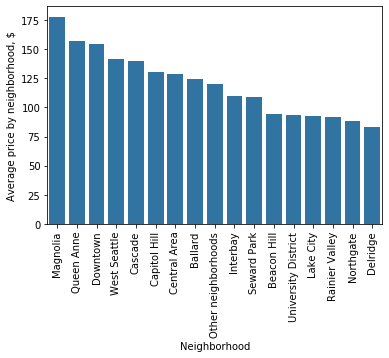

In [34]:
# 4. Find out the correlation between neighborhood and the price of rooms.
#get list of neighborhoods
neighbourhoods = df_listings_drop['neighbourhood_group_cleansed'].unique()

#find average price by neighborhoods
avg_price_neighbourhoods = df_listings_drop.groupby('neighbourhood_group_cleansed')['price'].mean().reset_index()
avg_price_neighbourhoods_order = avg_price_neighbourhoods.sort_values('price', ascending = False)
 
#make a bar chart
base_color = sns.color_palette()[0]
sns.barplot(data = avg_price_neighbourhoods_order, x = 'neighbourhood_group_cleansed', y = 'price', color = base_color)
plt.xticks(rotation=90);
plt.xlabel('Neighborhood')
plt.ylabel('Average price by neighborhood, $');

plt.savefig('average price by neighborhood')

Results: The bar chart above, we can see prices of rooms are different depending on the neighborhood. Customers prefer to stay in Magnolia, Queen Anne, and Downtown are most. Difference between highest area and lowest area is almost $100 per night.

3. What are the main factors that the price of rooms? 

  What other factors that affect the price of rooms? It can be property_type, the number of bedrooms or bathrooms, or number_of_reviews and so on. Let's figure out what are main factors that influence the price of rooms. 

Data Preparation

1. Change price format to float.
2. Remove columns that we don't need from listings.csv.
3. Remove rows which have Nan in price column.
4. Find out main factors that affect the price of rooms.

In [15]:
# 1. Change price format to float
df_listings['price'] = df_listings['price'].astype(str)
df_listings['price'] = df_listings['price'].str.replace("[$, ]", "").astype("float")


In [35]:
#2. Drop columns that we don't need.
df_listings_drop = df_listings[['host_since', 'host_total_listings_count', 
                                'property_type', 'room_type', 'accommodates', 
                                'bathrooms','bedrooms', 'beds', 'number_of_reviews', 
                                'review_scores_rating', 'price']]


In [36]:
# 3. Remove rows that have Nan in any column
# Selected columns' proportions of missing values are less than 0.2, so I just drop the rows. 
df_listings_drop_nan = df_listings_drop.dropna(how='any', axis=0)


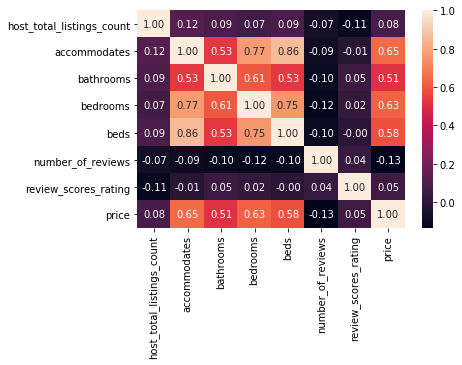

In [37]:
# 4. Find out main factors that affect the price of rooms.
sns.heatmap(df_listings_drop_nan.corr(), annot=True, fmt=".2f");
plt.savefig('average price by month')

Results: As seen in the heat map above, price is strongly related with accommodates, the number of bathrooms, bedrooms and beds. We can say that size of accommodation is key factor when hosts decide the price. 

Modeling

Consider only accomodates, the number of bathrooms, bedrooms and beds. 

Predict price based on accommodates, bathrooms, bedrooms, beds in the dataset. You can use the template above to assist in fitting your model:

Split the data into explanatory and response variables
Split the data into train and test (using seed of 42 and test_size of .30 as above)
Instantiate your linear model using normalized data
Fit your model on the training data
Predict using the test data
Compute a score for your model fit on all the data, and show how many rows you predicted for
Use the tests to assure you completed the steps correctly.

In [171]:
# Consider only numerical variables
X = df_listings_drop_nan[['accommodates', 'bathrooms','bedrooms', 'beds']]
y = df_listings_drop_nan['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

#Four steps:

#Instantiate
lm_model = LinearRegression(normalize=True) 

#Fit
lm_model.fit(X_train, y_train);

#Predict
y_test_preds = lm_model.predict(X_test)# Predictions here
r2_test = r2_score(y_test, y_test_preds) # Rsquared here

#Score: Print r2 to see result
"The r-squared score for your model was {} on {} values.".format(r2_test, len(y_test))


'The r-squared score for your model was 0.4734268113943739 on 946 values.'

In [178]:
# Fill numeric columns with the mean
num_vars = df_listings_drop.select_dtypes(include=['float', 'int']).columns
for col in num_vars:
    df_listings_drop[col].fillna((df_listings_drop[col].mean()), inplace=True);

In [179]:
# Consider only numerical variables
X = df_listings_drop[['accommodates', 'bathrooms','bedrooms', 'beds']]
y = df_listings_drop['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

#Four steps:

#Instantiate
lm_model = LinearRegression(normalize=True) 

#Fit
lm_model.fit(X_train, y_train);

#Predict
y_test_preds = lm_model.predict(X_test)# Predictions here
r2_test = r2_score(y_test, y_test_preds) # Rsquared here

#Score: Print r2 to see result
"The r-squared score for your model was {} on {} values.".format(r2_test, len(y_test))


'The r-squared score for your model was 0.4978313378126322 on 1146 values.'

Results: I used Linear Regression for this case. At first, I drop rows which have missing value in any column and the r-squared score for my model was 0.47. After that, I imputed the missing value with mean instead of removing rows, and the r-squared score for my model increase slightly. It was almos 0.5. 
    I guess it is enough score for this research since price is decided not only by these four factors but also by locations, seasons and so on. 

Conclusion

I analyze Airbnb data of Seattle to find out what factors are related to the price of rooms. I found following answer to my questions. 

1. What are the busiest times of the year to visit Seattle? By how much do prices spike? 

The busiest times of the year is summer and the time of year is related to prices. In the busy season, the number of listing decreased and prices increased. 

2. Can you describe the vibe of each Seattle neighborhood using listing descriptions?

I can say that neighborhood(location) affects the price of room. The most expensive location was Magnolia, and Queen Anne, and Downtwon follows it. Difference between highest area and lowest area is almost $100 per night.

3. What are the main factors that the price of rooms? 

I found that the structure of accomodations(ex)the number of accomodates, bedrooms, bathrooms, and bed) are strongly related to the price. Also, the number of review, number of review, the number of listings per host and some other factors also influence the price of rooms. 

If you have a plan to travel in Seattle, you can save money by selecting cheaper location and avoiding summer season. I think we can apply this model to other locations, too. There might be differences in busiest season or locations, but these factors could be main factors to decide the price of room in Airbnb.